<a href="https://www.kaggle.com/eavannan/house-price-prediction-simple-ml?scriptVersionId=86474281" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
trainingset = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
testset = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
o_submission = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv")

I am staring out my DS journey to practice what I have leaned so far. This competetion helped me to learn how to impute missing data, how to fix skewness, how to select features using Lasso, and how to fine-tune the parameters for the simple ML models such as Lasso and Ridge. 







In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from scipy.special import boxcox1p
import missingno as msno
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from xgboost import XGBRegressor


import warnings
warnings.filterwarnings('ignore')

def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 

pd.set_option("display.float_format", lambda x: "{:.3f}".format(x)) #Limiting floats output to 3 decimal points
pd.set_option("display.max_columns", None)

## Basic EDA

In [4]:
print(trainingset.shape)
print(testset.shape)

(1460, 81)
(1459, 80)


In [5]:
#trainingset.describe()

In [6]:
# checking duplication
trainingset.duplicated().sum()

0

Note: Train and test data have missing values in diffent columns. Handle all missing values later in the data processing stage.

In [7]:
train_null = trainingset.isnull().sum().sort_values(ascending=False)
train_null = train_null[train_null>0]

test_null = testset.isnull().sum().sort_values(ascending=False)
test_null = test_null[test_null>0]
missing_df = pd.concat([train_null,test_null, train_null/len(trainingset),test_null/len(testset), trainingset[train_null.index].dtypes, testset[test_null.index].dtypes], axis=1)
missing_df.rename({0: "train_null", 1: "test_null", 2: "train_null raito", 3: "test_null raito", 4: "dtype_train", 5: "dtype_test" },  axis='columns')

,train_null,test_null,train_null raito,test_null raito,dtype_train,dtype_test
PoolQC,1453.000,1456.000,0.995,0.998,object,object
MiscFeature,1406.000,1408.000,0.963,0.965,object,object
Alley,1369.000,1352.000,0.938,0.927,object,object
Fence,1179.000,1169.000,0.808,0.801,object,object
FireplaceQu,690.000,730.000,0.473,0.500,object,object
LotFrontage,259.000,227.000,0.177,0.156,float64,float64
GarageYrBlt,81.000,78.000,0.055,0.053,float64,float64
GarageCond,81.000,78.000,0.055,0.053,object,object
GarageType,81.000,76.000,0.055,0.052,object,object
GarageFinish,81.000,78.000,0.055,0.053,object,object


#### 1.1 Analyse target variable: SalePrice
* SalePrice has positive skewness.

In [8]:
trainingset.SalePrice.describe()

count     1460.000
mean    180921.196
std      79442.503
min      34900.000
25%     129975.000
50%     163000.000
75%     214000.000
max     755000.000
Name: SalePrice, dtype: float64

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

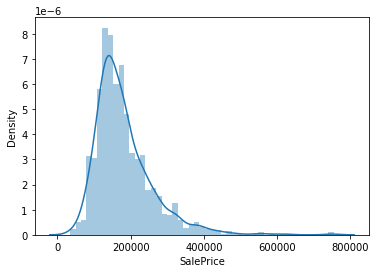

In [9]:
sns.distplot(trainingset.SalePrice)

In [10]:
skew = trainingset.SalePrice.skew()
kurt = trainingset.SalePrice.kurt()
print("Skew: {} /  Kurt: {}".format(skew, kurt))

Skew: 1.8828757597682129 /  Kurt: 6.536281860064529


#### 1.2 Bivariate analysis

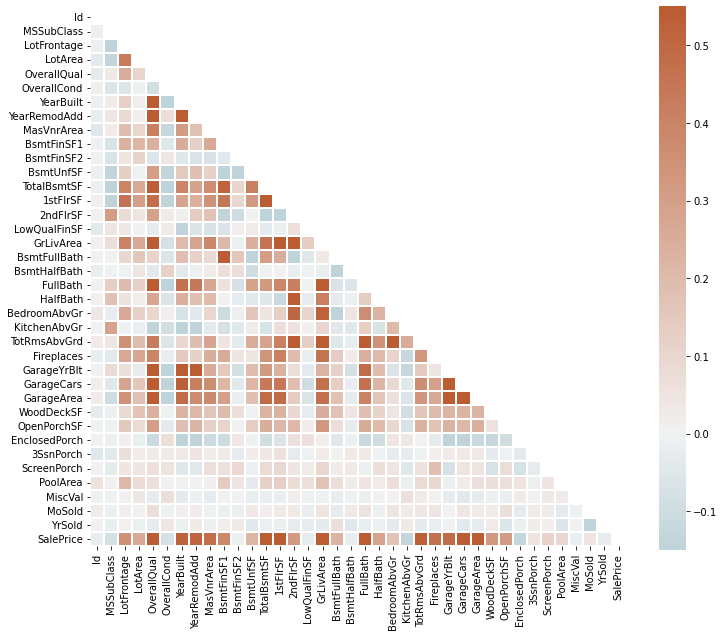

In [11]:
# Replace missging Age values based on other columns
# check correlation between different variables
matrix = trainingset.select_dtypes(exclude="object").corr()
mask = np.triu(np.ones_like(matrix, dtype=bool))
cmap = sns.diverging_palette(220, 25, s=80, n=9, as_cmap=True, center="light")
plt.figure(figsize=(12, 10))
sns.heatmap(matrix, mask = mask, annot=False, cmap=cmap, square=True, fmt='.2f',linewidth=.2, center=0, vmin=-0.15, vmax=0.55)
plt.show()


* SalePrice is highly corelated with 
'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt'

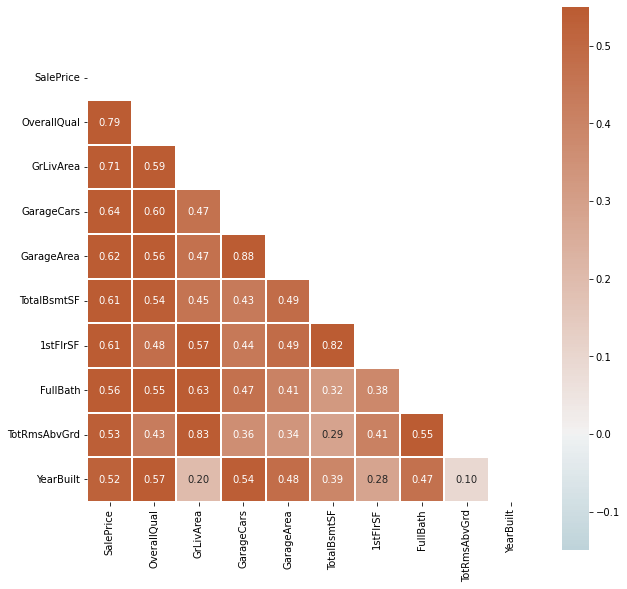

In [12]:
# Pick top 10 features that highly corelated to SalePrice
k = 10 #number of variables for heatmap
col_names = matrix.nlargest(k, 'SalePrice')['SalePrice'].index
coef_matrix = np.corrcoef(trainingset[col_names].values.T)
mask = np.triu(np.ones_like(coef_matrix, dtype=bool))
cmap = sns.diverging_palette(220, 25, s=80, n=9, as_cmap=True, center="light")
plt.figure(figsize=(10, 10))
sns.heatmap(coef_matrix, cbar=True, mask = mask, annot=True, cmap=cmap, square=True, fmt='.2f',linewidth=.2, center=0, vmin=-0.15, vmax=0.55, yticklabels=col_names.values, xticklabels=col_names.values)
plt.show()

* There are outliers in GrLivArea (bottom right corner), TotalBsmtSF, and 1stFlrSF
* After checking these outliers, ID 1298 is the common outliers for all three features, remove this later.
* GrLivArea also has another outlier ID 523, removing this later too.

* 1stFlrSF and TotalBsmtSF are highly correlated. (0.82)
* TotRmsAbvGrd and GrLiveArea are also highly correlated (0.83)
* GarageArea and GarageCards are highly correlated (0.88)



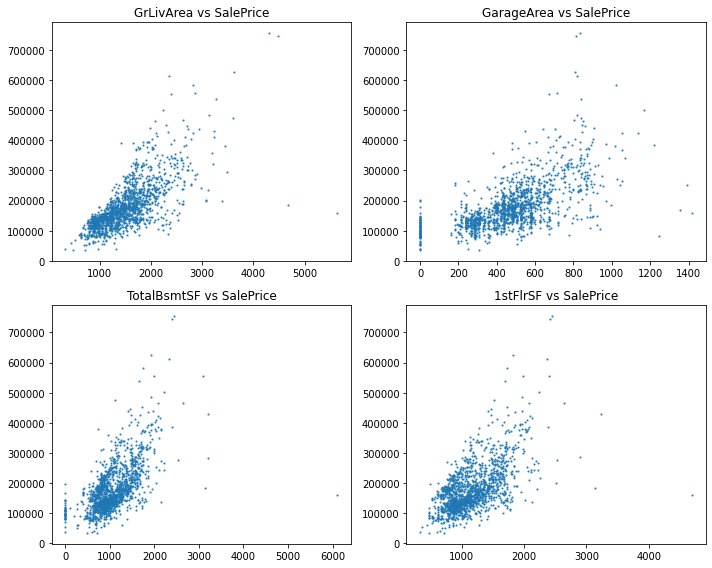

In [13]:
# plot multiple subplots to validate correlations
fig, axs = plt.subplots(2, 2, figsize=(10,8))
axs[0, 0].plot(trainingset.GrLivArea, trainingset.SalePrice, marker="o", linestyle="", markersize=1.2, alpha=.8)
axs[0, 0].set_title('GrLivArea vs SalePrice')
axs[0, 1].plot(trainingset.GarageArea, trainingset.SalePrice, marker="o", linestyle="", markersize=1.2, alpha=.8)
axs[0, 1].set_title('GarageArea vs SalePrice')
axs[1, 0].plot(trainingset.TotalBsmtSF, trainingset.SalePrice, marker="o", linestyle="", markersize=1.2, alpha=.8)
axs[1, 0].set_title('TotalBsmtSF vs SalePrice')
axs[1, 1].plot(trainingset["1stFlrSF"], trainingset.SalePrice, marker="o", linestyle="", markersize=1.2, alpha=.8)
axs[1, 1].set_title('1stFlrSF vs SalePrice')

fig.tight_layout()

<AxesSubplot:xlabel='TotRmsAbvGrd', ylabel='SalePrice'>

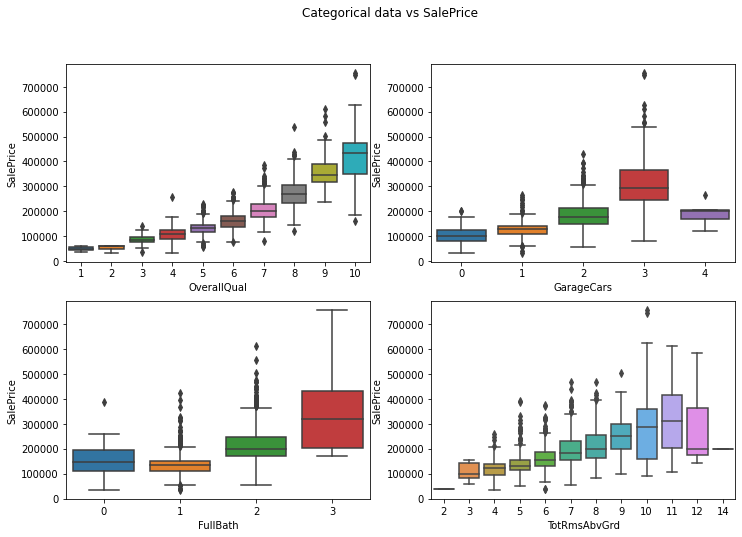

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Categorical data vs SalePrice')

sns.boxplot(ax=axes[0, 0], data=trainingset, x='OverallQual', y='SalePrice')
sns.boxplot(ax=axes[0, 1], data=trainingset, x='GarageCars', y='SalePrice')
sns.boxplot(ax=axes[1, 0], data=trainingset, x='FullBath', y='SalePrice')
sns.boxplot(ax=axes[1, 1], data=trainingset, x='TotRmsAbvGrd', y='SalePrice')




## Data Processing

### Handling Outliers

In [15]:
# removing two outliers in GrLivArea
print("Before: {}".format(trainingset.shape))
outlier_index = trainingset[(trainingset.GrLivArea > 4000) & (trainingset.SalePrice < 200000)].index
trainingset = trainingset.drop(outlier_index)
print("After: {}".format(trainingset.shape))


Before: (1460, 81)
After: (1458, 81)


In [16]:
#### Investigate 'LotFrontage'
# After checking plots below, droped two outliers in LotArea(one row)  and LotFrontage (two rows)
# sns.scatterplot(trainingset.LotArea, trainingset.SalePrice)
# sns.scatterplot(trainingset.LotFrontage, trainingset.SalePrice)

# removing outliers in LotFrontage and LotArea
trainingset = trainingset.loc[trainingset.LotArea != max(trainingset.LotArea), :] # one row
trainingset = trainingset.loc[trainingset.LotFrontage != max(trainingset.LotFrontage), :] # one row
print("trainingset data size: {}".format(trainingset.shape))
print("After: {}".format(trainingset.shape))

trainingset data size: (1456, 81)
After: (1456, 81)


### Handling Missing Values
##### Notes:
* NA values can cause errors with machine learning later down the line, so I will impute the missing values.
* PoolQC, MiscFeature, Alley, Fence columns have more than 80% of missing values. If there are no good ways to figure out the values, I will drop these columns. The rest columns (FireplaceQu, Lotfrontage etc.) need to impute missing values.
* Based on MSNO graph, features start with 'Garage' in the trainingset have the same number of missing data. 
* Based on MSNO graph, Features start with 'Bsmt' in the trainingset have the same number of missing data. 

In [17]:
nullcols_train = [col for col in trainingset.columns if trainingset[col].isnull().any()]
nullcols_test = [col for col in testset.columns if testset[col].isnull().any()]
print(nullcols_train, len(nullcols_train))
print(nullcols_test, len(nullcols_test))

['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'] 19
['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType'] 33


<AxesSubplot:>

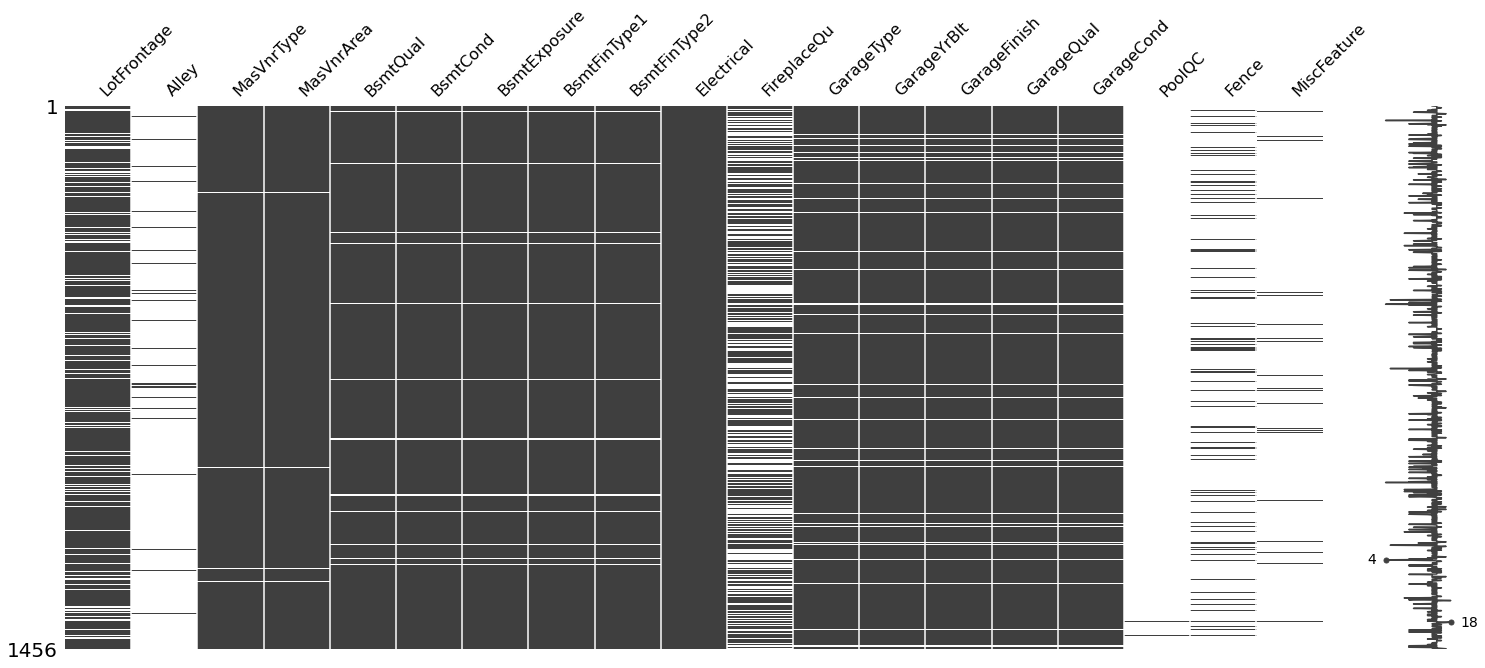

In [18]:
# Visualise missing values.
msno.matrix(trainingset.loc[:, nullcols_train])
# #msno.matrix(trainingset.select_dtypes(include="object")) 
# #msno.matrix(testset.loc[:, test_null.index])

In [19]:
# PoolQC : data description says NA means "No Pool". 
# MiscFeature : data description says NA means "no misc feature".
# Alley : data description says NA means "no alley access".
# Fence: data description says NA means "no fence". 
# FireplaceQu: data description says NA meand "NoFireplace". 
# Features start with 'Garage' in the trainingset have the same number of missing data. 
#-----GarageType, GarageFinish,GarageCond, GarageQual : data description says NA means "No Garage". 
#-----GarageYrBlt has NA beacause the property does not have garage.
#-----GarageArea and GarageCars in the testset has one missing value each beacuse the property does not have a garage according to GarageQual column.
# Features start with 'Bsmtuniquere missing same data.
#-----BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2 : data description says NA means "No Basement". 
#-----'BsmtFullBath','BsmtHalfBath','BsmtUnfSF', 'TotalBsmtSF' : data is missing because there is no basement.
# MasVnrType, MasVnrArea : Data is missing probably there is no veneer. (8 values are missing in the trainingset.)
values = {
    "PoolQC": "None",
    "MiscFeature": "None",
    "Alley": "None",
    "Fence": "None",
    "FireplaceQu": "None",
    "GarageType": "None",
    "GarageFinish": "None",    
    "GarageCond": "None",
    "GarageQual": "None",
    "GarageYrBlt": 1880.0, #No garage, give an artificial year here    
    "GarageArea": 0,#No garage
    "GarageCars": 0,#No garage
    "BsmtExposure": "None",#No basement
    "BsmtFinType2": "None",#No basement
    "BsmtFinType1": "None",#No basement
    "BsmtCond": "None",#No basement
    "BsmtQual": "None",#No basement
    "BsmtFullBath":0, #No basement
    "BsmtHalfBath":0, #No basement
    "BsmtUnfSF":0, #No basement
    "BsmtFinSF2":0, #No basement
    "BsmtFinSF1":0, #No basement
    "TotalBsmtSF":0, #No basement
    "MasVnrArea": 0,#No Veneer
    "MasVnrType": "None"
}

trainingset.fillna(value=values, inplace=True)
testset.fillna(value=values, inplace=True)


In [20]:
# Electrical, MSZoning,Exterior2nd, Exterior1st, SaleType, KitchenQual: these columns have one or two missing values, 
# imputing missing values with the most common category in the corresponding column.
most_common_cols = ["Electrical", "MSZoning", "Exterior1st", "Exterior2nd", "SaleType", "KitchenQual"]
for col in most_common_cols:
    trainingset[col] = trainingset[col].fillna(trainingset[col].mode()[0])
    testset[col] = testset[col].fillna(testset[col].mode()[0])

#data description says "Assume typical unless deductions are warranted"
testset["Functional"] = testset["Functional"].fillna("Typ") 

#LotFrontage : Since the area of each street connected to the house property most likely have 
# a similar area to other houses in its neighborhood, fill in missing values by the median LotFrontage of the same neighborhood.
trainingset["LotFrontage"] = trainingset.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
testset["LotFrontage"] = testset.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))


#### Handle Low Variance columns

In [21]:
# Check low variance columns in categorical columns
results = {}
def valueCount(df):
    df_filter = df.select_dtypes(include="object")
    for col in df_filter.columns:
        result = df_filter[col].value_counts(normalize=True) 
        results["------" + col + "------"] = result
    return results

valueCount(trainingset)

{'------MSZoning------': RL        0.788
 RM        0.150
 FV        0.045
 RH        0.011
 C (all)   0.007
 Name: MSZoning, dtype: float64,
 '------Street------': Pave   0.996
 Grvl   0.004
 Name: Street, dtype: float64,
 '------Alley------': None   0.938
 Grvl   0.034
 Pave   0.028
 Name: Alley, dtype: float64,
 '------LotShape------': Reg   0.635
 IR1   0.332
 IR2   0.027
 IR3   0.005
 Name: LotShape, dtype: float64,
 '------LandContour------': Lvl   0.900
 Bnk   0.042
 HLS   0.034
 Low   0.024
 Name: LandContour, dtype: float64,
 '------Utilities------': AllPub   0.999
 NoSeWa   0.001
 Name: Utilities, dtype: float64,
 '------LotConfig------': Inside    0.720
 Corner    0.180
 CulDSac   0.065
 FR2       0.032
 FR3       0.003
 Name: LotConfig, dtype: float64,
 '------LandSlope------': Gtl   0.948
 Mod   0.044
 Sev   0.008
 Name: LandSlope, dtype: float64,
 '------Neighborhood------': NAmes     0.154
 CollgCr   0.103
 OldTown   0.078
 Edwards   0.067
 Somerst   0.059
 Gilbert   0.0

* Select low variance columns from the value_counts above and remove them as these columns are dominated by one single value and not informative to our target at all.
* For instance, 99% of Street has only one value "Pave" 

In [22]:
# 99% of Street has only one value "Pave" 
low_variance_cols = ['Street','Utilities', 'Heating','RoofMatl','Condition2', 'PoolQC', 'MiscFeature'] 
for col in low_variance_cols:
    print(trainingset[col].value_counts(normalize=True)) 
trainingset = trainingset.drop(low_variance_cols,axis=1) # drop 7 columns
testset = testset.drop(low_variance_cols,axis=1) # drop 7 columns

Pave   0.996
Grvl   0.004
Name: Street, dtype: float64
AllPub   0.999
NoSeWa   0.001
Name: Utilities, dtype: float64
GasA    0.979
GasW    0.012
Grav    0.005
Wall    0.003
OthW    0.001
Floor   0.001
Name: Heating, dtype: float64
CompShg   0.984
Tar&Grv   0.007
WdShngl   0.004
WdShake   0.003
Metal     0.001
Membran   0.001
Roll      0.001
Name: RoofMatl, dtype: float64
Norm     0.990
Feedr    0.004
Artery   0.001
RRNn     0.001
PosA     0.001
PosN     0.001
RRAn     0.001
RRAe     0.001
Name: Condition2, dtype: float64
None   0.996
Ex     0.001
Fa     0.001
Gd     0.001
Name: PoolQC, dtype: float64
None   0.963
Shed   0.034
Gar2   0.001
Othr   0.001
TenC   0.001
Name: MiscFeature, dtype: float64


In [23]:
# check if all missing data are imputed.
print(trainingset.isnull().sum().any())
print(testset.isnull().sum().any())
# Check data shapes
print(trainingset.shape)
print(testset.shape)

False
False
(1456, 74)
(1459, 73)


#### Handling Skewness in data
In skewed data, the tail region may act as an outlier for the statistical model and we know that outliers adversely affect the model’s performance especially regression-based models. There are statistical model that are robust to outlier like a Tree-based models but it will limit the possibility to try other models. So there is a necessity to transform the skewed data to close enough to a Gaussian distribution or Normal distribution. This will allow us to try more number of statistical model.


* Before fixing skewness in data, tree-based models performed better.
* After fixing skewness in data, linear models performed better.

The rule of thumb seems to be:
* If the skewness is between -0.5 and 0.5, the data are fairly symmetrical.
* If the skewness is between -1 and -0.5(negatively skewed) or between 0.5 and 1(positively skewed), the data are moderately skewed.
* If the skewness is less than -1(negatively skewed) or greater than 1(positively skewed), the data are highly skewed.

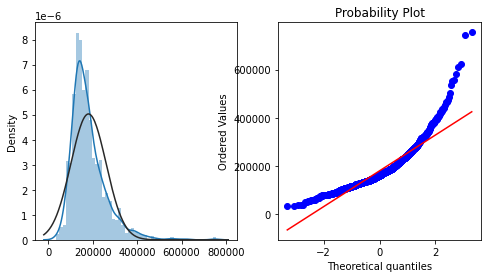

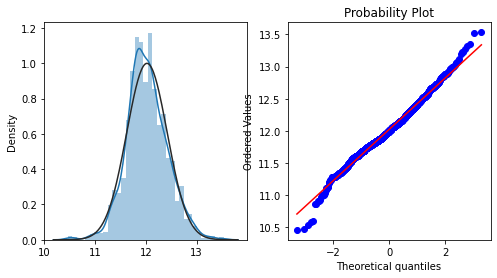

In [24]:
#Before handling skewness in SalePrice
#histogram and normal probability plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
sns.distplot(ax=axs[0], x=trainingset['SalePrice'], fit=norm);
stats.probplot(x= trainingset['SalePrice'], plot=plt)
plt.show()

# After handling skewness
# Applying log transformation on columns without zero values
trainingset["SalePrice"] = np.log(trainingset["SalePrice"])

# Transformed histogram and normal probability plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
sns.distplot(ax=axs[0], x=trainingset['SalePrice'], fit=norm);
stats.probplot(x= trainingset['SalePrice'], plot=plt)
plt.show()

In [25]:
numerical_cols = trainingset.select_dtypes(exclude="object").columns
numerical_cols = numerical_cols.drop("Id")
highly_skewed_cols = [col for col in numerical_cols if np.abs(trainingset[col].skew()) > 0.75] #20 columns

# Using boxcox from scipy library to fix skewness
lam = 0.15
for col in highly_skewed_cols:
    trainingset[col] = boxcox1p(trainingset[col], lam)
    testset[col] = boxcox1p(testset[col], lam)

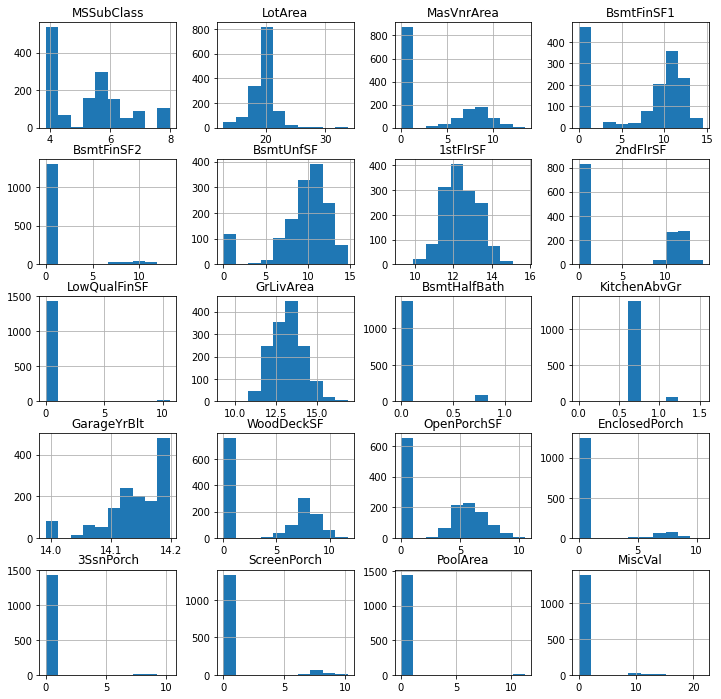

In [26]:
trainingset[highly_skewed_cols].hist(figsize=(12,12))
plt.show()

### Check homoscedasticity

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

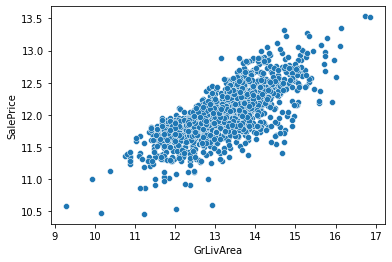

In [27]:
sns.scatterplot(trainingset.GrLivArea, trainingset.SalePrice)

<AxesSubplot:xlabel='1stFlrSF', ylabel='SalePrice'>

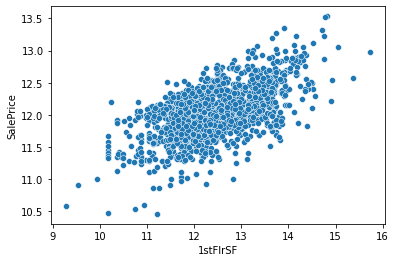

In [28]:
sns.scatterplot(trainingset["1stFlrSF"], trainingset.SalePrice)

#### Handle oridinal columns

In [29]:
ordinal_cols = ["ExterQual", "ExterCond", "BsmtCond", "BsmtQual","HeatingQC", "KitchenQual", 
                "FireplaceQu","GarageQual", "GarageCond", "BsmtFinType1", "BsmtFinType2"]
bin_map  = {'Ex':4, 'Gd':3,'TA':2, 'Fa':1,'Po':1,  'None':0, 
            "GLQ" : 6, "Unf" : 1, "LwQ": 2, "Rec" : 3,"BLQ" : 4, "ALQ" : 5
            }
for col in ordinal_cols:
    trainingset[col] = trainingset[col].map(bin_map)
    testset[col] = testset[col].map(bin_map)

    
BsmtExposure = {"Gd" : 4, "Av": 3, "Mn" : 2, 'No': 1, "None":0}
trainingset['BsmtExposure'] = trainingset['BsmtExposure'].map(BsmtExposure)
testset['BsmtExposure'] = testset['BsmtExposure'].map(BsmtExposure)

PavedDrive =   {"Y" : 2, "N" : 0, "P" : 1}
trainingset['PavedDrive'] = trainingset['PavedDrive'].map(PavedDrive)
testset['PavedDrive'] = testset['PavedDrive'].map(PavedDrive)

In [30]:
print(trainingset.shape)
print(testset.shape)

(1456, 74)
(1459, 73)


In [31]:
print(trainingset.isnull().sum().any())
print(testset.isnull().sum().any())

False
False


# Feature selection with Lasso

I ran the following code to select important features first and then fit various models only with the selected features.

In [32]:
# print("{}{}".format(trainingset.shape, testset.shape))

# # Spliting Data
# X = trainingset.drop(["Id","SalePrice"], axis=1)
# y = trainingset.SalePrice
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print("{}{}{}{}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

# result = {}
# def evaluation(y, y_pred):
#     r_squared = r2_score(y, y_pred),
#     mae = mean_absolute_error(y, y_pred),
#     mse = mean_squared_error(y, y_pred),
#     rmse = np.sqrt(mean_squared_error(y, y_pred))
#     return r_squared, mae, mse, rmse

# low_cardinality_cols = [col for col in X_train.columns if (X_train[col].dtype=="object") & (X_train[col].nunique()<26)]
# #print(len(low_cardinality_cols), low_cardinality_cols)

# column_trans = make_column_transformer(
#     (OneHotEncoder(handle_unknown="ignore", sparse=False),low_cardinality_cols),
#     remainder='passthrough'
# )
# sc = StandardScaler()


# model = Lasso() 
# pipe = make_pipeline(column_trans, sc, model) 
# params = {"lasso__alpha": np.arange(0.001,0.005,0.001)} #print(pipe.get_params().keys())
# cv_lasso = GridSearchCV(pipe, param_grid=params)
# cv_lasso.fit(X_train, y_train)
# preds_lasso = cv_lasso.predict(X_test)
# preds_lasso = np.exp(preds_lasso) #inverse logrithm on predicted SalePrice.


# lasso_r2, lasso_mae, lasso_mse, lasso_rmse = evaluation(y_test, preds_lasso) 
# print(lasso_r2,lasso_mae, lasso_mse, lasso_rmse)
# print(cv_lasso.best_params_, cv_lasso.best_score_)

# ############################
# # Plot feature graph

# temp_df = pd.DataFrame(column_trans.fit_transform(X_train), columns=column_trans.get_feature_names())
# cols = temp_df.columns 
# temp_df = pd.DataFrame(sc.fit_transform(temp_df), columns=cols)
# names = cols
# lasso = Lasso(alpha=0.003)
# lasso_coef = lasso.fit(temp_df, y_train).coef_

# # pick important features
# names_n = np.array(names)[np.abs(lasso_coef)>0.005]
# lasso_coef_n = lasso_coef[np.abs(lasso_coef)>0.005]
# print(len(names_n),len(lasso_coef_n))

# _ = plt.figure(figsize=(8,8))
# _ = plt.plot(range(len(names_n)), lasso_coef_n,  'bo-')
# _ = plt.xticks(range(len(names_n)), names_n, rotation=90)
# _ = plt.ylabel('Coefficients')
# plt.show()

Tried with different threshold of lasso coef and finally selected the best performing threshold.
* np.abs(lasso_coef)>0.005, which gave me 36 important features.

In [33]:
# cat_names = ['MSZoning', 'Alley', 'LotShape','LandContour', 'LotConfig', 'LandSlope',
#                    'Neighborhood', 'Condition1', 'BldgType','HouseStyle', 
#                    'RoofStyle', 'Exterior1st','Exterior2nd', 'MasVnrType', 'Foundation',
#                    'CentralAir', 'Electrical', 'Functional',
#                    'GarageType', 'GarageFinish', 'Fence','SaleType', 'SaleCondition']
# for i, v in enumerate(cat_names):
#     print(i, ":", v)

# #names_n

############# Selected features after fixing the skewness ############# 
# # # # Threshold: abs(Lasso coef)> 0 (after fixed skewness)
# features_53 = ['MSZoning','Alley','LotShape', 'LandContour','LotConfig', 'LandSlope', 'Neighborhood',
# 'Condition1','BldgType', 'HouseStyle','RoofStyle', 'Exterior1st', 'Exterior2nd','MasVnrType','Foundation',
# 'CentralAir', 'Functional', 'GarageType', 'GarageFinish','Fence',  'SaleType','SaleCondition',
# 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond','YearBuilt', 'YearRemodAdd', 'ExterQual', 'BsmtQual',
# 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'HeatingQC', '1stFlrSF', 'GrLivArea',
# 'BsmtFullBath', 'FullBath', 'HalfBath', 'KitchenAbvGr','KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 
#  'FireplaceQu','GarageCars', 'GarageArea', 'GarageQual', 'WoodDeckSF','OpenPorchSF', 'ScreenPorch', 'PoolArea']

# # find highly correlated features
# corr_matrix = trainingset[features_53].corr().abs()
# # Select upper triangle of correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# # Find features with correlation greater than 0.8
# to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
# print(to_drop)
# feature_selection = set(features_53) - set(to_drop)
# print(len(feature_selection))


############# Selected features before fixing the skewness ############# 
# # Threshold: abs(Lasso coef)> 0
# selected_features_64 = ['MSZoning', 'Alley', 'LotShape','LandContour', 'LotConfig', 'LandSlope', 
#                         'Neighborhood', 'Condition1', 'BldgType','HouseStyle', 'RoofStyle', 
#                         'Exterior1st','Exterior2nd', 'MasVnrType', 'Foundation',
#                         'Functional','GarageType', 'GarageFinish', 'Fence','SaleType', 'SaleCondition',
#                         'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual','OverallCond', 
#                         'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 
#                         'BsmtQual', 'BsmtCond', 'BsmtExposure','BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 
#                         'TotalBsmtSF','HeatingQC', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 
#                         'HalfBath', 'BedroomAbvGr','KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 
#                         'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageCars', 'GarageArea',
#                         'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF','OpenPorchSF', 
#                         '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MoSold', 'YrSold']

# # Threshold: abs(Lasso coef)> 1000
# selected_features_48 = ['MSZoning', 'LotShape', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType','HouseStyle', 'Exterior1st',
#  'Exterior2nd', 'MasVnrType', 'Foundation', 'Functional','GarageType',  'Fence','SaleCondition', 'MSSubClass', 'LotArea','OverallQual', 'OverallCond', 'YearBuilt', 'MasVnrArea','ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
# 'BsmtFinType1', 'BsmtFinSF1', 'TotalBsmtSF', '2ndFlrSF','LowQualFinSF', 'GrLivArea', 
# 'BsmtFullBath', 'HalfBath','BedroomAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces',
# 'FireplaceQu', 'GarageCars', 'GarageArea', 'GarageQual','WoodDeckSF', 'OpenPorchSF', 
# '3SsnPorch', 'ScreenPorch','PoolArea', 'MoSold']


# # Threshold: abs(Lasso coef)> 2000
# selected_features_31 = ['LandSlope', 'Neighborhood','BldgType','HouseStyle', 
#                         'Exterior1st','MasVnrType', 'Functional','GarageFinish','SaleCondition',
#                         'MSSubClass', 'LotArea','OverallQual', 'OverallCond', 'YearBuilt', 
#                         'MasVnrArea','ExterQual', 'ExterCond', 'BsmtQual', 'BsmtExposure', 'BsmtFinSF1',
#                         'TotalBsmtSF', '2ndFlrSF', 'GrLivArea', 'BedroomAbvGr','KitchenQual', 
#                         'TotRmsAbvGrd', 'GarageCars', 'GarageArea','GarageQual', 'OpenPorchSF', 'PoolArea']

# # Threshold: abs(Lasso coef)> 7000
# selected_features_5 = ['SaleType', 'OverallQual', 'YearBuilt', 'BsmtFinSF1','GrLivArea']




In [34]:
# # Threshold: abs(Lasso coef)> 0.005 (after fixed skewness)
# features_36 = ['MSZoning', 'LotConfig','Neighborhood', 'Condition1', 'BldgType', 'Exterior1st','MasVnrType', 
#  'Foundation','CentralAir', 'Functional','SaleType', 'SaleCondition', 'LotArea', 'OverallQual',
#  'OverallCond', 'YearBuilt', 'YearRemodAdd', 'ExterQual','BsmtQual', 'BsmtExposure', 
#  'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', 'GrLivArea', 'BsmtFullBath',
#  'HalfBath', 'KitchenAbvGr', 'KitchenQual','Fireplaces', 'GarageCars', 'GarageArea', 'GarageQual',
#  'WoodDeckSF', 'ScreenPorch']

############# Remove redundant features #################
# removed two highly correlated features: 1stFlrSF and GarageCards
# 1stFlrSF and TotalBsmtSF are highly correlated. (0.82)
# TotRmsAbvGrd and GrLiveArea are also highly correlated (0.83)
# GarageArea and GarageCards are highly correlated (0.88)
feature_selection = ['MSZoning', 'LotConfig','Neighborhood', 'Condition1', 'BldgType', 'Exterior1st','MasVnrType', 
 'Foundation','CentralAir', 'Functional','SaleType', 'SaleCondition', 'LotArea', 'OverallQual',
 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'ExterQual','BsmtQual', 'BsmtExposure', 
 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC',  'GrLivArea', 'BsmtFullBath',
 'HalfBath', 'KitchenAbvGr', 'KitchenQual','Fireplaces', 'GarageArea', 'GarageQual',
 'WoodDeckSF', 'ScreenPorch']




# Build Models with selected features

In [35]:
print("{}{}".format(trainingset.shape, testset.shape))

# Spliting Data
X = trainingset[feature_selection]
y = trainingset.SalePrice
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("{}{}{}{}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

(1456, 74)(1459, 73)
(1164, 34)(1164,)(292, 34)(292,)


In [36]:
result = {}
def evaluation(y, y_pred):
    r_squared = r2_score(y, y_pred),
    mae = mean_absolute_error(y, y_pred),
    mse = mean_squared_error(y, y_pred),
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    return r_squared, mae, mse, rmse

In [37]:
low_cardinality_cols = [col for col in X_train.columns if (X_train[col].dtype=="object") & (X_train[col].nunique()<26)]
#print(len(low_cardinality_cols), low_cardinality_cols)

column_trans = make_column_transformer(
    (OneHotEncoder(handle_unknown="ignore", sparse=False),low_cardinality_cols),
    remainder='passthrough'
)
sc = StandardScaler()

#### Linear Regression

In [38]:
model = LinearRegression() 
pipe = make_pipeline(column_trans, model) 
pipe.fit(X_train, y_train)
preds_lm = pipe.predict(X_test)
preds_lm = np.exp(preds_lm) #inverse logrithm on predicted SalePrice.
print(pipe.score(X_test, y_test))
pd.DataFrame(preds_lm.reshape(len(preds_lm),1)).describe()

0.9113962394085362


,0
count,292.000
mean,175582.951
std,73891.135
min,51303.661
25%,125830.223
50%,157211.136
75%,208888.929
max,530327.108


#### Lasso

In [39]:
model = Lasso() 
pipe = make_pipeline(column_trans, sc, model) 
params = {"lasso__alpha": np.arange(0.001,0.002,0.0001)} #print(pipe.get_params().keys())
cv_lasso = GridSearchCV(pipe, param_grid=params)
cv_lasso.fit(X_train, y_train)
preds_lasso = cv_lasso.predict(X_test)
preds_lasso = np.exp(preds_lasso) #inverse logrithm on predicted SalePrice.
lasso_r2, lasso_mae, lasso_mse, lasso_rmse = evaluation(y_test, preds_lasso) 
print(cv_lasso.best_params_, cv_lasso.best_score_)

{'lasso__alpha': 0.0014000000000000002} 0.9184897259214804


#### Ridge

In [40]:
model = Ridge() 
pipe = make_pipeline(column_trans, sc, model) 
params = {"ridge__alpha": np.arange(1,100,10)} #print(pipe.get_params().keys())
cv_ridge = GridSearchCV(pipe, param_grid=params)
cv_ridge.fit(X_train, y_train)
preds_ridge = cv_ridge.predict(X_test)
preds_ridge = np.exp(preds_ridge) #inverse logrithm on predicted SalePrice.
print(cv_ridge.best_params_, cv_ridge.best_score_)


{'ridge__alpha': 21} 0.9176388642181956


#### ElasticNet

In [41]:
model = ElasticNet()
pipe = make_pipeline(column_trans, sc, model) 
#print(pipe.get_params().keys())
params = {"elasticnet__alpha": np.arange(0,0.2,0.01)} 
cv_elastic = GridSearchCV(pipe, param_grid=params)
cv_elastic.fit(X_train, y_train)
preds_elastic = cv_elastic.predict(X_test)
preds_elastic = np.exp(preds_elastic) #inverse logrithm on predicted SalePrice.
print(cv_elastic.best_params_, cv_elastic.best_score_)


{'elasticnet__alpha': 0.0} 0.9169826705402014


#### SVM

In [42]:
model = SVR()
pipe = make_pipeline(column_trans, sc, model) 
#print(pipe.get_params().keys())
params = {"svr__C": np.arange(1,1.6,0.1)} 
cv_svr = GridSearchCV(pipe, param_grid=params)
cv_svr.fit(X_train, y_train)
preds_svr = cv_svr.predict(X_test)
preds_svr = np.exp(preds_svr) #inverse logrithm on predicted SalePrice.
print(cv_svr.best_params_, cv_svr.best_score_)


{'svr__C': 1.3000000000000003} 0.8243757067733156


#### Stochstic Gradient Descent

In [43]:
model = SGDRegressor()
pipe = make_pipeline(column_trans, sc, model) 
#print(pipe.get_params().keys())
params = {"sgdregressor__tol": [1e-3], #stopping criteria
          "sgdregressor__n_iter_no_change": [200],
          "sgdregressor__eta0": [0.006, 0.009, 0.01, 0.03], 
          "sgdregressor__alpha": np.arange(0.005,0.1,0.005),
          "sgdregressor__random_state": [42]
         }
cv_sgd = GridSearchCV(pipe, param_grid=params)
cv_sgd.fit(X_train, y_train)
preds_sgd = cv_sgd.predict(X_test)
preds_sgd = np.exp(preds_sgd) #inverse logrithm on predicted SalePrice.
print(cv_sgd.best_params_, cv_sgd.best_score_)


pd.DataFrame(preds_sgd.reshape(len(preds_sgd),1)).describe()

{'sgdregressor__alpha': 0.025, 'sgdregressor__eta0': 0.009, 'sgdregressor__n_iter_no_change': 200, 'sgdregressor__random_state': 42, 'sgdregressor__tol': 0.001} 0.9180466982719523


,0
count,292.000
mean,175702.078
std,72885.327
min,51712.984
25%,125614.323
50%,158165.168
75%,208395.390
max,521606.708


#### Randome Forest Resgression

In [44]:
model = RandomForestRegressor()
pipe = make_pipeline(column_trans, model) 
#print(pipe.get_params().keys())
params = {"randomforestregressor__n_estimators": np.arange(50,150,50)} 
cv_rf = GridSearchCV(pipe, param_grid=params)
cv_rf.fit(X_train, y_train)
preds_rf = cv_rf.predict(X_test)
preds_rf = np.exp(preds_rf) #inverse logrithm on predicted SalePrice.
pd.DataFrame(preds_rf.reshape(len(preds_rf),1)).describe()
print(cv_rf.best_params_, cv_rf.best_score_)


{'randomforestregressor__n_estimators': 100} 0.8784615407423036


#### XGBoost

In [45]:
model = XGBRegressor()
pipe = make_pipeline(column_trans, model) 
#print(pipe.get_params().keys())
params = {"xgbregressor__n_estimators": np.arange(100,200,50), "xgbregressor__learning_rate": np.arange(0.08,0.12,0.01)} 
cv_xg = GridSearchCV(pipe, param_grid=params)
cv_xg.fit(X_train, y_train)
preds_xg = cv_xg.predict(X_test)
preds_xg = np.exp(preds_xg) #inverse logrithm on predicted SalePrice.
pd.DataFrame(preds_xg.reshape(len(preds_xg),1)).describe()
print(cv_xg.best_params_, cv_xg.best_score_)


{'xgbregressor__learning_rate': 0.09, 'xgbregressor__n_estimators': 150} 0.904769258770908


### Model comparison

In [46]:
lm_r2, lm_mae, lm_mse, lm_rmse = evaluation(np.exp(y_test), preds_lm) 
result["Liner"] = [lm_r2, lm_mae, lm_mse, lm_rmse]

lasso_r2, lasso_mae, lasso_mse, lasso_rmse = evaluation(np.exp(y_test), preds_lasso) 
result["Lasso"] = [lasso_r2,lasso_mae, lasso_mse, lasso_rmse]

ridge_r2, ridge_mae, ridge_mse, ridge_rmse = evaluation(np.exp(y_test), preds_ridge) 
result["Ridge"] = [ridge_r2, ridge_mae, ridge_mse, ridge_rmse]

elastic_r2, elastic_mae, elastic_mse, elastic_rmse = evaluation(np.exp(y_test), preds_elastic) 
result["Elastic"] = [elastic_r2, elastic_mae, elastic_mse, elastic_rmse]

svr_r2, svr_mae, svr_mse, svr_rmse = evaluation(np.exp(y_test), preds_svr) 
result["SVR"] = [svr_r2, svr_mae, svr_mse, svr_rmse]

rf_r2, rf_mae, rf_mse, rf_rmse = evaluation(np.exp(y_test), preds_rf) 
result["RandomForest"] = [rf_r2, rf_mae, rf_mse, rf_rmse]

xg_r2, xg_mae, xg_mse, xg_rmse = evaluation(np.exp(y_test), preds_rf) 
result["XGBoost"] = [xg_r2, xg_mae, xg_mse, xg_rmse]


sgd_r2, sgd_mae, sgd_mse, sgd_rmse = evaluation(np.exp(y_test), preds_sgd) 
result["Stochastic"] = [sgd_r2, sgd_mae, sgd_mse, sgd_rmse]




In [47]:
result = pd.DataFrame.from_dict(result, orient='index', columns=["R2 Score","MAE","MSE","RMSE"])
result.sort_values(by="RMSE")


,R2 Score,MAE,MSE,RMSE
Ridge,"(0.9435081993040226,)","(12753.60224215331,)","(363776440.67842054,)",19072.924
Lasso,"(0.9431825031968224,)","(12688.133147058199,)","(365873746.2902165,)",19127.826
Stochastic,"(0.9425118863619075,)","(12811.15805817147,)","(370192153.6034696,)",19240.378
Liner,"(0.9394561767754026,)","(13137.277774610857,)","(389869259.72207236,)",19745.107
Elastic,"(0.9394546196324983,)","(13137.909585507285,)","(389879286.8746209,)",19745.361
RandomForest,"(0.9021920678897696,)","(16146.538914768033,)","(629829833.2648084,)",25096.411
XGBoost,"(0.9021920678897696,)","(16146.538914768033,)","(629829833.2648084,)",25096.411
SVR,"(0.8501370472933797,)","(17479.503980859452,)","(965035825.6159254,)",31065.026


<AxesSubplot:ylabel='RMSE'>

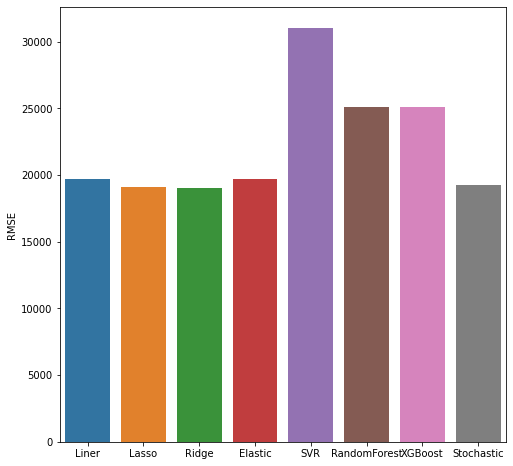

In [48]:
plt.figure(figsize=(8,8))
sns.barplot(result.index,result.RMSE)


### Output

In [49]:
test_X = testset[feature_selection]
# model = RandomForestRegressor(n_estimators=100)
# pipe = make_pipeline(column_trans, model) 
# pipe.fit(X_train, y_train)
# predictions = pipe.predict(test_X)
# pd.DataFrame(predictions.reshape(len(predictions),1)).describe()


# model = XGBRegressor(n_estimators=150, learning_rate=0.08)
# pipe = make_pipeline(column_trans, model) 
# pipe.fit(X_train, y_train)
# predictions = pipe.predict(test_X)
# predictions = np.exp(predictions) #inverse logrithm on predicted SalePrice.

model = Lasso(alpha=0.0014) 
pipe = make_pipeline(column_trans, sc, model) 
pipe.fit(X_train, y_train)
predictions = pipe.predict(test_X)
predictions = np.exp(predictions) #inverse logrithm on predicted SalePrice.
pd.DataFrame(predictions.reshape(len(predictions),1)).describe()


# model = Ridge(alpha=21) 
# pipe = make_pipeline(column_trans, sc, model) 
# pipe.fit(X_train, y_train)
# predictions = pipe.predict(test_X)
# predictions = np.exp(predictions) #inverse logrithm on predicted SalePrice.
# pd.DataFrame(predictions.reshape(len(predictions),1)).describe()

,0
count,1459.000
mean,178442.351
std,77884.290
min,41106.976
25%,126840.702
50%,157344.508
75%,212304.828
max,1034094.800


In [50]:
output_dic = {"Id": testset["Id"], "SalePrice": predictions}
output_df = pd.DataFrame(output_dic)
output_df.to_csv("submission.csv", index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


### Experiment: Learning Curve

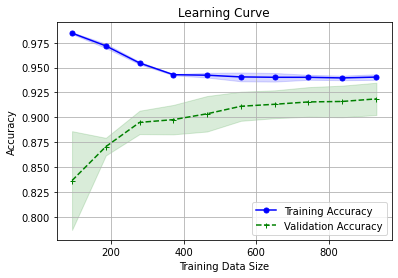

In [51]:
from sklearn.model_selection import learning_curve
# Use learning curve to get training and test scores along with train sizes
train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipe, 
    X=X_train, 
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=1,
    cv=5
)

#
# Calculate training and test mean and std
#
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
#
# Plot the learning curve
#
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

In [52]:
############# Fix Skewness ##################
# #trainingset.loc[:,highly_skewed_cols].describe()
# has_zero_cols = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '2ndFlrSF', 'LowQualFinSF', 
# 'KitchenAbvGr', 'BsmtHalfBath',  'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 
#  'MiscVal']
# non_zero_cols = ['MSSubClass', 'LotArea', '1stFlrSF', 'GrLivArea','GarageYrBlt']

# for col in non_zero_cols:
#     trainingset[col] = np.log(trainingset[col])

# # Handle cols with zero values
# for col in has_zero_cols:
#     trainingset[col + '_flag'] = trainingset[col]>0
#     trainingset.loc[trainingset[col + '_flag']==1,col] = np.log(trainingset[col])

# # Drop columns with _flag where I created to perform log transformation on the columns contain zero values.
# trainingset = trainingset[trainingset.columns.drop(list(trainingset.filter(regex='_flag')))]




## References

Feature selection lecture: [UW Machine Learning: Regression](https://www.coursera.org/learn/ml-regression?specialization=machine-learning)
    
I've read some great notebooks in Kaggle. Regarding imputing missing values, I refered the notebook below.
* [Handling Missing Values](https://www.kaggle.com/dansbecker/handling-missing-values ) by DANB.
* [Using Categorical Data with One Hot Encoding](https://www.kaggle.com/dansbecker/using-categorical-data-with-one-hot-encoding) by DANB.
* [Stacked Regressions : Top 4% on LeaderBoard](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard) by Serigne.

The note below has a stragetic approach about EDA. 
* [Comprehensive data exploration with Python](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python) by PEDRO MARCELINO

Transforming skewed data (why and how)
* [Skewed Data: A problem to your statistical model](https://towardsdatascience.com/skewed-data-a-problem-to-your-statistical-model-9a6b5bb74e37)
* [Transforming Skewed Data for Machine Learning](https://odsc.medium.com/transforming-skewed-data-for-machine-learning-90e6cc364b0)
* https://codeburst.io/2-important-statistics-terms-you-need-to-know-in-data-science-skewness-and-kurtosis-388fef94eeaa

